In [1]:
import psycopg2 as pg2
import pandas as pd

con = pg2.connect(host='this_postgres', user='postgres', database='postgres')
con.autocommit = True
cur = con.cursor()

def select(sql):
    return pd.read_sql(sql,con)

In [2]:
sql = '''
drop table if exists sales_month;
create table sales_month as
select 

t.*,
s.invoice_cnt,
s.unitprice_sum,
1 as customer,
case when s.invoice_cnt > 0 then 1 else 0 end as active,


extract(year from age(t.month, max(case when s.invoice_cnt > 0 then t.month else null end) 
over (partition by t.customerid order by t.month))) * 12 +
extract(month from age(t.month, max(case when s.invoice_cnt > 0 then t.month else null end) 
over (partition by t.customerid order by t.month))) as last_order_cnt



from user_month_1 t 

left join sales_month_agg s on t.customerid = s.customerid and
t.month = s.month

'''

In [3]:
cur.execute(sql)

In [4]:
sql = '''select * from sales_month t
where t.customerid = 12347.0
order by t.month'''

In [5]:
select(sql)

,customerid,reg_month,month,invoice_cnt,unitprice_sum,customer,active,last_order_cnt
0,12347.0,2010-12-01,2010-12-01,1.0,89.59,1,1,0.0
1,12347.0,2010-12-01,2011-01-01,1.0,73.17,1,1,0.0
2,12347.0,2010-12-01,2011-02-01,NaN,NaN,1,0,1.0
3,12347.0,2010-12-01,2011-03-01,NaN,NaN,1,0,2.0
4,12347.0,2010-12-01,2011-04-01,1.0,62.29,1,1,0.0
5,12347.0,2010-12-01,2011-05-01,NaN,NaN,1,0,1.0
6,12347.0,2010-12-01,2011-06-01,1.0,53.62,1,1,0.0
7,12347.0,2010-12-01,2011-07-01,NaN,NaN,1,0,1.0
8,12347.0,2010-12-01,2011-08-01,1.0,68.24,1,1,0.0
9,12347.0,2010-12-01,2011-09-01,NaN,NaN,1,0,1.0


In [6]:
sql = '''select t.month, sum(t.customer) as customer,
sum(t.invoice_cnt) as invoice,
sum(t.unitprice_sum) as revenue,

sum(t.active) as active,

sum(t.active) * 1.0 / sum(t.customer) as active_pct,

lag(sum(t.customer),1) over (order by t.month) as prev_customer,


sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end) as churn_3mnt_cnt,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end) as churn_4mnt_cnt,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end) as churn_5mnt_cnt,
sum(case when t.last_order_cnt >= 6 then 1 else 0 end) as churn_6mnt_cnt,


sum(case when t.last_order_cnt >= 2 then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_2mnt_cnt_pct,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_3mnt_cnt_pct,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_4mnt_cnt_pct,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_5mnt_cnt_pct,
sum(case when t.last_order_cnt >= 6 then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_6mnt_cnt_pct


from sales_month t 
group by t.month
order by t.month'''

In [7]:
df = select(sql)

In [8]:
for i in range(2,7):
    print(f'sum(case when t.last_order_cnt >= {i} then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_{i}mnt_cnt_pct,')

sum(case when t.last_order_cnt >= 2 then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_2mnt_cnt_pct,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_3mnt_cnt_pct,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_4mnt_cnt_pct,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_5mnt_cnt_pct,
sum(case when t.last_order_cnt >= 6 then 1 else 0 end) * 1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_6mnt_cnt_pct,


In [9]:
df.columns

Index(['month', 'customer', 'invoice', 'revenue', 'active', 'active_pct',
       'prev_customer', 'churn_2mnt_cnt', 'churn_3mnt_cnt', 'churn_4mnt_cnt',
       'churn_5mnt_cnt', 'churn_6mnt_cnt', 'churn_2mnt_cnt_pct',
       'churn_3mnt_cnt_pct', 'churn_4mnt_cnt_pct', 'churn_5mnt_cnt_pct',
       'churn_6mnt_cnt_pct'],
      dtype='object')

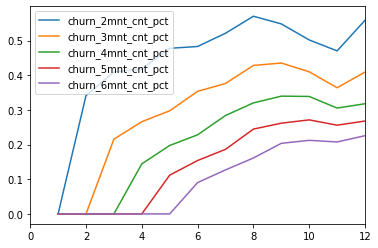

In [10]:
df[['churn_2mnt_cnt_pct',
       'churn_3mnt_cnt_pct', 'churn_4mnt_cnt_pct', 'churn_5mnt_cnt_pct',
       'churn_6mnt_cnt_pct']].plot()

In [11]:
df

,month,customer,invoice,revenue,active,active_pct,prev_customer,churn_2mnt_cnt,churn_3mnt_cnt,churn_4mnt_cnt,churn_5mnt_cnt,churn_6mnt_cnt,churn_2mnt_cnt_pct,churn_3mnt_cnt_pct,churn_4mnt_cnt_pct,churn_5mnt_cnt_pct,churn_6mnt_cnt_pct
0,2010-12-01,948,1708.0,86057.190,948,1.000000,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2011-01-01,1369,1236.0,73202.320,783,0.571950,948.0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2011-02-01,1749,1202.0,67529.430,798,0.456261,1369.0,467,0,0,0,0,0.341125,0.000000,0.000000,0.000000,0.000000
3,2011-03-01,2189,1619.0,96183.240,1020,0.465966,1749.0,716,377,0,0,0,0.409377,0.215552,0.000000,0.000000,0.000000
4,2011-04-01,2488,1384.0,91117.721,899,0.361334,2189.0,915,582,316,0,0,0.417999,0.265875,0.144358,0.000000,0.000000
5,2011-05-01,2767,1849.0,125537.660,1079,0.389953,2488.0,1188,740,491,278,0,0.477492,0.297428,0.197347,0.111736,0.000000
6,2011-06-01,3002,1707.0,129301.450,1051,0.350100,2767.0,1336,978,631,426,250,0.482833,0.353451,0.228045,0.153957,0.090351
7,2011-07-01,3193,1593.0,92754.521,993,0.310993,3002.0,1564,1129,852,559,381,0.520986,0.376083,0.283811,0.186209,0.126915
8,2011-08-01,3360,1544.0,88126.750,980,0.291667,3193.0,1820,1367,1022,781,515,0.569997,0.428124,0.320075,0.244598,0.161290
9,2011-09-01,3658,2078.0,126029.422,1302,0.355932,3360.0,1841,1462,1141,879,684,0.547917,0.435119,0.339583,0.261607,0.203571
